In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [4]:
import env
import acquire
import split_scale
import features

In [5]:
url = acquire.get_db_url('zillow')

In [6]:
def wrangle_zillow():
    df = pd.read_sql("""
SELECT 
p17.transactiondate,p.id,p.bathroomcnt as bathrooms,p.bedroomcnt as bedrooms, p.calculatedfinishedsquarefeet as sqft, p.taxvaluedollarcnt as tax_value
FROM propertylandusetype pl
JOIN
properties_2017 p ON p.propertylandusetypeid = pl.propertylandusetypeid
JOIN
predictions_2017 p17 ON p17.id = p.id
WHERE 
p.propertylandusetypeid in (279,261) 
AND 
(p17.transactiondate LIKE '%%2017-05%%' or p17.transactiondate LIKE '%%2017-06%%')
AND
p.calculatedfinishedsquarefeet IS NOT NULL
and
p.bedroomcnt > 0
and 
p.bathroomcnt > 0
and
p.taxvaluedollarcnt > 0
"""
,url)
    return df

In [7]:
df = wrangle_zillow()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15982 entries, 0 to 15981
Data columns (total 6 columns):
transactiondate    15982 non-null object
id                 15982 non-null int64
bathrooms          15982 non-null float64
bedrooms           15982 non-null float64
sqft               15982 non-null float64
tax_value          15982 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 749.2+ KB


In [9]:
def zillow_tax():
    df = pd.read_sql("""
    SELECT p.taxvaluedollarcnt as tax_value, p.fips, p.taxamount, round(p.taxamount/p.taxvaluedollarcnt,4) as tax_rate 
FROM propertylandusetype pl
JOIN
properties_2017 p ON p.propertylandusetypeid = pl.propertylandusetypeid
JOIN
predictions_2017 p17 ON p17.id = p.id
WHERE 
p.propertylandusetypeid in (279,261) 
AND 
(p17.transactiondate LIKE '%%2017-05%%' or p17.transactiondate LIKE '%%2017-06%%')
AND
p.calculatedfinishedsquarefeet IS NOT NULL
and
p.bedroomcnt > 0
and 
p.bathroomcnt > 0
and
p.taxvaluedollarcnt > 0
and
p.taxamount > 0
""",url)
    return df


In [10]:
df_tax = zillow_tax()

In [11]:
df_tax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15956 entries, 0 to 15955
Data columns (total 4 columns):
tax_value    15956 non-null float64
fips         15956 non-null float64
taxamount    15956 non-null float64
tax_rate     15956 non-null float64
dtypes: float64(4)
memory usage: 498.7 KB


In [14]:
df_tax.head()

,tax_value,fips,taxamount,tax_rate,county
0,498347.0,6037.0,6089.82,0.0122,Los Angles
1,549917.0,6037.0,6679.55,0.0121,Los Angles
2,235272.0,6037.0,3876.31,0.0165,Los Angles
3,340000.0,6037.0,4206.15,0.0124,Los Angles
4,2017254.0,6037.0,24353.42,0.0121,Los Angles


In [ ]:
df.head()

In [12]:
df_tax['county']=df_tax['fips']

In [13]:
df_tax['county'] = np.where(df_tax['fips']== 6037,'Los Angles',(np.where(df_tax['fips']== 6059,'Orange',(np.where(df_tax['fips']==6111,'Ventura',"")))))

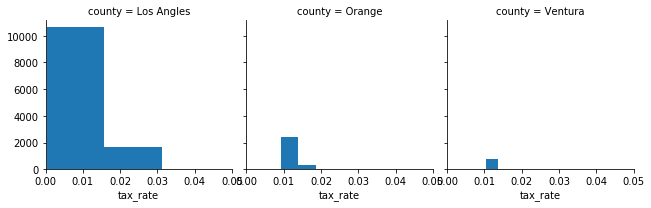

In [60]:
from matplotlib import pyplot as plt

g = sns.FacetGrid(df_tax, col = "county")
g.map(plt.hist, "tax_rate")
plt.xlim(0,.05)
#plt.xticks(np.arange(0, .07, step=0.01))

plt.show()

In [ ]:
df = df.set_index(['id'])

In [34]:
df.drop('transactiondate',axis=1,inplace=True)

In [35]:
train, test = split_scale.split_my_data(df,train_ratio=.8,seed=123)

In [36]:
X_train = train.drop(columns='tax_value')
y_train = train[['tax_value']]
X_test = test.drop(columns='tax_value')
y_test = test[['tax_value']]

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12785 entries, 41126 to 36422
Data columns (total 4 columns):
bathrooms    12785 non-null float64
bedrooms     12785 non-null float64
sqft         12785 non-null float64
tax_value    12785 non-null float64
dtypes: float64(4)
memory usage: 499.4 KB


In [38]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3197 entries, 51627 to 51126
Data columns (total 4 columns):
bathrooms    3197 non-null float64
bedrooms     3197 non-null float64
sqft         3197 non-null float64
tax_value    3197 non-null float64
dtypes: float64(4)
memory usage: 124.9 KB


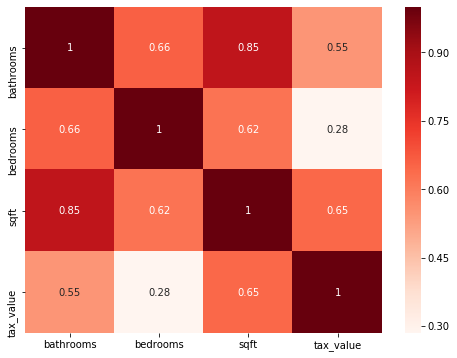

In [39]:
plt.figure(figsize=(8,6))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [40]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#OLS object to analyze features

# ols_model = sm.OLS(y_train,X_train)
# fit = ols_model.fit()
# fit.summary()

ols_model = ols('y_train ~ X_train',data=train).fit()
train['yhat'] = ols_model.predict(y_train)

In [41]:
#r2 of 
r2_lm1 = r2_score(y_train,train.yhat)
r2_lm1

0.4447042156038722

In [42]:
train['tax_mean'] = train.tax_value.mean()

In [43]:
train['residual'] = train['yhat'] - train['tax_value']
train['residual2'] = train.residual **2

In [44]:
train.head(1)

,bathrooms,bedrooms,sqft,tax_value,yhat,tax_mean,residual,residual2
id,,,,,,,,
41126,2.0,3.0,1381.0,314307.0,279325.544463,463464.489402,-34981.455537,1.223702e+09


In [45]:
from sklearn.linear_model import LinearRegression
#pick model type, Linear Regression for the MVP baseline
lm1 = LinearRegression()

In [46]:
#fit and train model
lm1.fit(X_train,y_train)
lm1_y_intercept = lm1.intercept_
lm1_coefficients = lm1.coef_

#print('{} = b + m1 * {} + m2 * {}'.format(y_train.columns[0], X_train.columns[0],X_train.columns[1]))
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])
#print('    coefficient (m2): %.2f' % lm1_coefficients[0][1])

    y-intercept  (b): -33592.49
    coefficient (m1): 60947.32


In [47]:
blob = y_train.tax_value

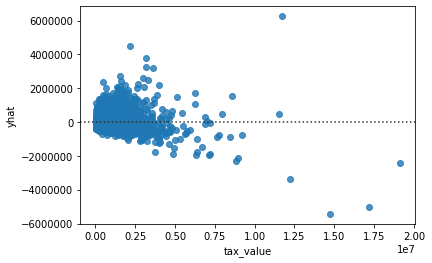

In [50]:
sns.residplot(blob,train.yhat)

In [51]:
import math
sse = sum(train.residual2)
mse = sse/len(train)
rmse = math.sqrt(mse)
r2 = ols_model.rsquared
print(sse,mse,rmse,r2)

2991275764154674.0 233967599855.66476 483701.9742110474 0.4447042156038725


Text(0.5, 1, 'Predicted vs Actual Tax Value')

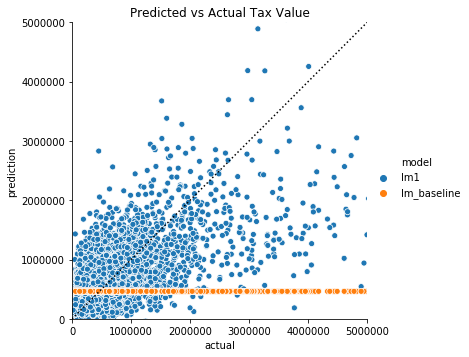

In [57]:
pd.DataFrame({'actual': blob,
              'lm1': train.yhat,
              'lm_baseline': train.tax_mean})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

min, max = 0, 5_000_000
plt.plot([min, max], [min, max], c='black', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')

Text(0.5, 1.0, 'Predicted vs Actual Tax Value')

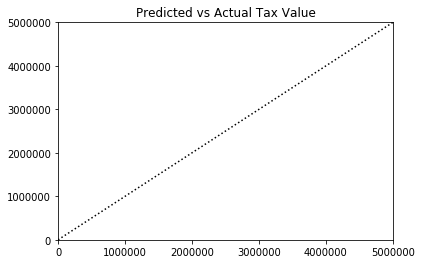

In [54]:
# min, max = 0, 5_000_000
# plt.plot([min, max], [min, max], c='black', ls=':')
# plt.ylim(min, max)
# plt.xlim(min, max)
# plt.title('Predicted vs Actual Tax Value')